# Part B — Multi-class Classification (reusing Part A pipeline)

This notebook reuses the **same preprocessing idea from Part A**:
- Load `events.json` → flatten `Records`
- Pick the same categorical features → one-hot encode

**Change for Part B:** the target `y` is **multi-class** (e.g., `Normal`, `CryptoJacking`, `LateralMovement`, …) and the main metric is **Weighted F1**.

Because the provided `events.json` has no explicit `attackType` column, we create `attack_label` from the **actor (user/role) name** using a mapping


## 1) Imports


In [1]:
import json
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, accuracy_score, classification_report

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


## 2) Load the dataset (same as Part A)




In [2]:
#cell 2
import json
import pandas as pd

with open("Datasets/events.json") as f:
    data = json.load(f)

df = pd.DataFrame(data)
print(df.head())
print(df.columns)
print(df.shape)


                                             Records
0  {'eventVersion': '1.08', 'userIdentity': {'typ...
1  {'eventVersion': '1.08', 'userIdentity': {'typ...
2  {'eventVersion': '1.08', 'userIdentity': {'typ...
3  {'eventVersion': '1.08', 'userIdentity': {'typ...
4  {'eventVersion': '1.08', 'userIdentity': {'typ...
Index(['Records'], dtype='object')
(107116, 1)


## 3) Flatten `Records` (same as Part A)


In [3]:
records_df = pd.json_normalize(df['Records'])
print(records_df.shape)
records_df.head()


(107116, 946)


,eventVersion,eventTime,eventSource,eventName,awsRegion,sourceIPAddress,userAgent,responseElements,requestID,eventID,...,responseElements.vpc.dhcpOptionsId,responseElements.vpc.instanceTenancy,responseElements.vpc.tagSet.items,responseElements.vpc.isDefault,responseElements.keyPairId,requestParameters.fullyQualifiedArn.arnPrefix.partition,requestParameters.fullyQualifiedArn.arnPrefix.region,requestParameters.fullyQualifiedArn.arnPrefix.account,requestParameters.fullyQualifiedArn.relativeId.functionName,requestParameters.dryRun
0,1.08,2023-04-23T10:45:02Z,lambda.amazonaws.com,ListFunctions20150331,us-east-1,212.179.179.106,aws-sdk-go-v2/1.17.6 os/macos lang/go/1.19.8 m...,NaN,003011fb-368c-4c9c-be0a-06748de885d8,1c5ce35b-9daf-4edb-9caf-48ba82d71bf1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.08,2023-04-23T10:44:40Z,iam.amazonaws.com,GetCredentialReport,us-east-1,212.179.179.106,aws-sdk-go-v2/1.17.6 os/macos lang/go/1.19.8 m...,NaN,3977d934-4be7-40aa-8faf-d747825f8704,e247cda3-35b8-4ef8-a440-c2478b6d400f,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.08,2023-04-23T10:44:39Z,iam.amazonaws.com,GetCredentialReport,us-east-1,212.179.179.106,aws-sdk-go-v2/1.17.6 os/macos lang/go/1.19.8 m...,NaN,0e50e798-b866-4351-a5f9-18b5ea76a643,d257ea8a-e162-47d4-8b8e-6ae1d14df751,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.08,2023-04-23T10:44:30Z,iam.amazonaws.com,GetCredentialReport,us-east-1,212.179.179.106,aws-sdk-go-v2/1.17.6 os/macos lang/go/1.19.8 m...,NaN,74269e4e-1bd1-49ef-9b63-32b0b72c7595,653e7bd9-6d8b-49b5-8fbf-40d443bc06c4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.08,2023-04-23T10:44:26Z,iam.amazonaws.com,GetAccountPasswordPolicy,us-east-1,212.179.179.106,aws-sdk-go-v2/1.17.6 os/macos lang/go/1.19.8 m...,NaN,b7f8cc32-23a6-4904-ba0b-671f894096fa,ef4679c3-6880-4ae2-8679-96bd8872b068,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4) Create the multi-class label (attack type)

The `events.json` contains only one top-level column: `Records`. That means there is **no ready-made label column** like `attackType`.

For Part B we therefore **build a multi-class label** from information inside each record.
In this version I derive the label mainly from the **actor (user/role) name**, using the mapping was provided.



In [4]:
import numpy as np

#Build an 'actor' column (user/role name)
def pick_actor(row):
    candidates = [
        row.get('userIdentity.userName'),
        row.get('userIdentity.sessionContext.sessionIssuer.userName'),
        row.get('userIdentity.sessionContext.sessionIssuer.arn'),
        row.get('userIdentity.arn'),
        row.get('userIdentity.principalId'),
    ]
    for v in candidates:
        if pd.notna(v) and str(v).strip() != '':
            return str(v)
    return 'Unknown'

records_df['actor'] = records_df.apply(pick_actor, axis=1)
print('Top actors:')
print(records_df['actor'].value_counts().head(20))

# Map actors to attack labels
NORMAL_LABEL = 'Normal'

# Mapping from your notes
actor_to_label = {
    'cloud_user': 'CryptoJacking',
    'sec_check': 'TargetedVulnerabilities',
    'vpc_peering': 'LateralMovement',
    'Final_instance': 'LateralMovement',
    'Flask-server': 'LateralMovement',
    'Backend_server': 'LateralMovement',
    'Secmonkey': 'VulnerabilityScanning',

}

# Base label from actor mapping
records_df['attack_label'] = records_df['actor'].map(actor_to_label).fillna(NORMAL_LABEL)

print('Label distribution:')
print(records_df['attack_label'].value_counts())


Top actors:
actor
backup                                                                     37463
Level6                                                                     17171
SecurityMonkey                                                             16347
Unknown                                                                    15029
arn:aws:iam::123456789:root                                                 7598
sec-check                                                                   7375
cloud_user                                                                  3241
test                                                                         710
Cloudsploit                                                                  568
flaws                                                                        495
config-role-us-west-2                                                        352
final_instance                                                               248
arn:aws:st

## 5) Define the target `y` (multi-class)

I used the label we created above (`attack_label`).



In [5]:
y = records_df['attack_label'].astype(str)

print('Number of classes:', y.nunique())
print(y.value_counts())

# Quick peek at a few examples per class
for lbl in y.unique():
    ex = records_df.loc[records_df['attack_label'].eq(lbl), ['actor','eventName','eventSource']].head(3)
    print('\n===', lbl, '===')
    display(ex)


Number of classes: 3
attack_label
Normal             103859
CryptoJacking        3241
LateralMovement        16
Name: count, dtype: int64

=== Normal ===


,actor,eventName,eventSource
0,sec-check,ListFunctions20150331,lambda.amazonaws.com
1,sec-check,GetCredentialReport,iam.amazonaws.com
2,sec-check,GetCredentialReport,iam.amazonaws.com



=== CryptoJacking ===


,actor,eventName,eventSource
103834,cloud_user,StartInstances,ec2.amazonaws.com
103835,cloud_user,StartInstances,ec2.amazonaws.com
103836,cloud_user,StartInstances,ec2.amazonaws.com



=== LateralMovement ===


,actor,eventName,eventSource
105852,vpc_peering,DescribeRouteTables,ec2.amazonaws.com
105853,vpc_peering,DescribeRouteTables,ec2.amazonaws.com
105854,vpc_peering,GetCallerIdentity,sts.amazonaws.com


## 6) Build features `X` (reuse Part A selected columns)

I reused Part A feature list and do one-hot encoding.


In [6]:
selected_cols = [
    'eventName',
    'eventSource',
    'awsRegion',
    'sourceIPAddress',
    'userAgent',
    'eventType',
    'readOnly',
]

selected_cols = [c for c in selected_cols if c in records_df.columns]

X_df = records_df[selected_cols].copy().fillna('Unknown')
X = pd.get_dummies(X_df, drop_first=True)

print('X shape:', X.shape)
print('y classes:', y.nunique())


X shape: (107116, 5067)
y classes: 3


## 7) Encode labels + Train/Test split (stratified)


In [7]:
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

print('Train size:', X_train.shape[0])
print('Test  size:', X_test.shape[0])


Train size: 85692
Test  size: 21424


## 8) Train multi-class models

- Fast linear logistic regression via SGD

I used `class_weight='balanced'` to reduce the impact of class imbalance.


In [8]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import LinearSVC
#
# lr = LogisticRegression(
#     max_iter=1000,            # lower
#     solver="saga",
#     class_weight="balanced",
#     n_jobs=-1,
#     multi_class="ovr",        # MUCH faster than multinomial for many classes
#     tol=1e-3
# )
#
# svm = LinearSVC(
#     class_weight="balanced",
#     random_state=42,
#     dual="auto",
#     max_iter=10000,           # lower
#     tol=1e-3
# )
#
# lr.fit(X_train, y_train)
# svm.fit(X_train, y_train)
#
# pred_lr = lr.predict(X_test)
# pred_svm = svm.predict(X_test)
from sklearn.svm import LinearSVC
from scipy import sparse

# Ensure sparse matrices (big speed + memory win)
if not sparse.issparse(X_train):
    X_train = sparse.csr_matrix(X_train)
    X_test  = sparse.csr_matrix(X_test)

svm = LinearSVC(
    class_weight="balanced",
    random_state=42,
    dual="auto",
    max_iter=10000,
    tol=1e-3
)

svm.fit(X_train, y_train)
pred = svm.predict(X_test)


## 9) Evaluate (Weighted F1 + Accuracy)


In [9]:
from sklearn.metrics import f1_score, accuracy_score, classification_report

print("LinearSVC weighted-F1:", f1_score(y_test, pred, average="weighted"),
      " accuracy:", accuracy_score(y_test, pred))

print("\n _____LinearSVC report_____")
print(classification_report(y_test, pred, target_names=le.classes_))

# lr_f1w  = f1_score(y_test, pred_lr,  average='weighted')
# svm_f1w = f1_score(y_test, pred_svm, average='weighted')
#
# lr_acc  = accuracy_score(y_test, pred_lr)
# svm_acc = accuracy_score(y_test, pred_svm)
#
# print('LogReg   weighted-F1:', lr_f1w,  ' accuracy:', lr_acc)
# print('LinearSVC weighted-F1:', svm_f1w, ' accuracy:', svm_acc)
#
# print('\n=== Logistic Regression report ===')
# print(classification_report(y_test, pred_lr, target_names=le.classes_))
#
# print('\n=== LinearSVC report ===')
# print(classification_report(y_test, pred_svm, target_names=le.classes_))



LinearSVC weighted-F1: 0.9994532557561463  accuracy: 0.9994398805078417

 _____LinearSVC report_____
                 precision    recall  f1-score   support

  CryptoJacking       0.98      1.00      0.99       648
LateralMovement       0.60      1.00      0.75         3
         Normal       1.00      1.00      1.00     20773

       accuracy                           1.00     21424
      macro avg       0.86      1.00      0.91     21424
   weighted avg       1.00      1.00      1.00     21424



5-fold CV Weighted F1

In [10]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

svm_cv = LinearSVC(
    class_weight="balanced",
    random_state=42,
    dual="auto",
    max_iter=10000,
    tol=1e-3
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(svm_cv, X, y_enc, cv=cv, scoring="f1_weighted")

print("Weighted-F1 CV scores:", scores)
print("Mean:", scores.mean(), "Std:", scores.std())


Weighted-F1 CV scores: [0.9996293  0.99990664 0.9994836  0.99945323 0.99981322]
Mean: 0.999657196747424 Std: 0.0001783722043357053


## 10) Confusion Matrix (for the best model)




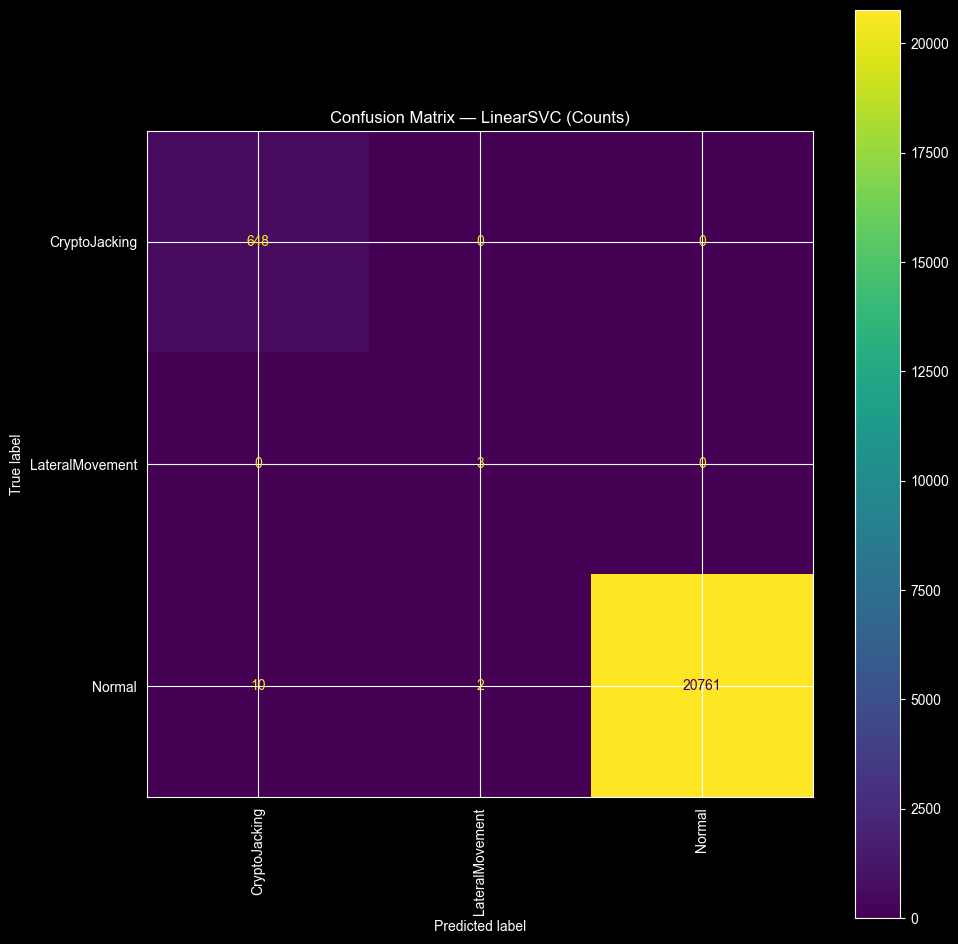

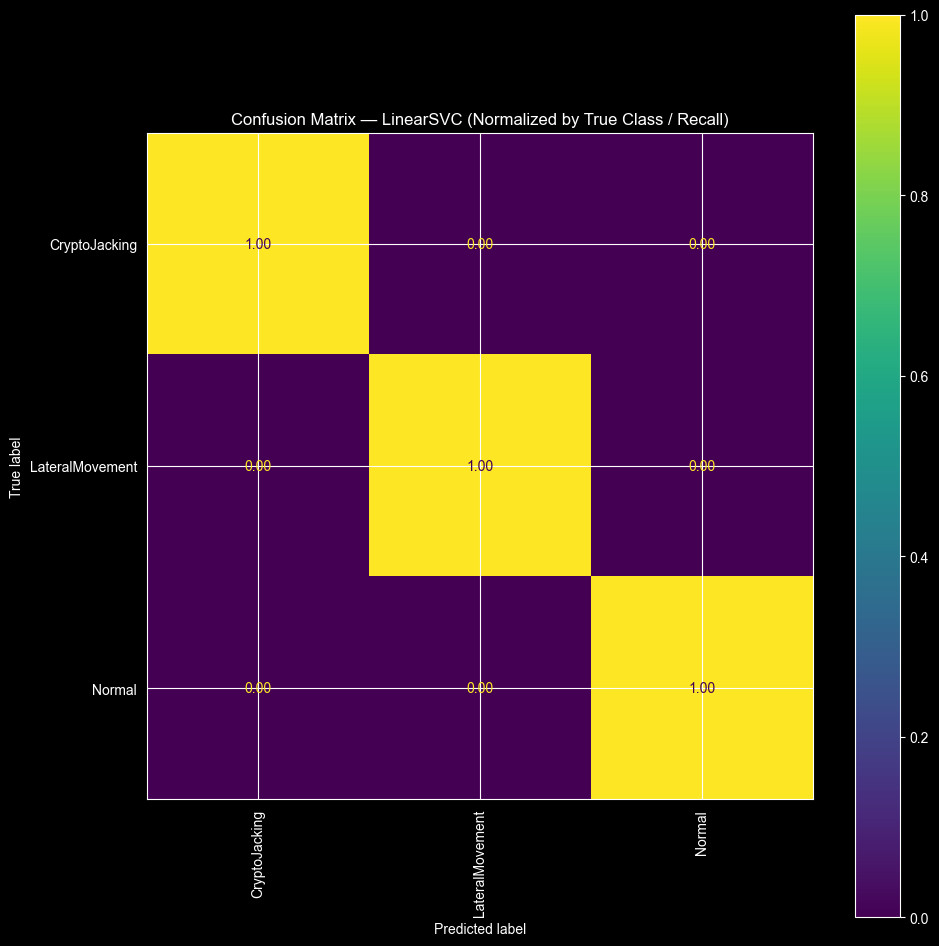

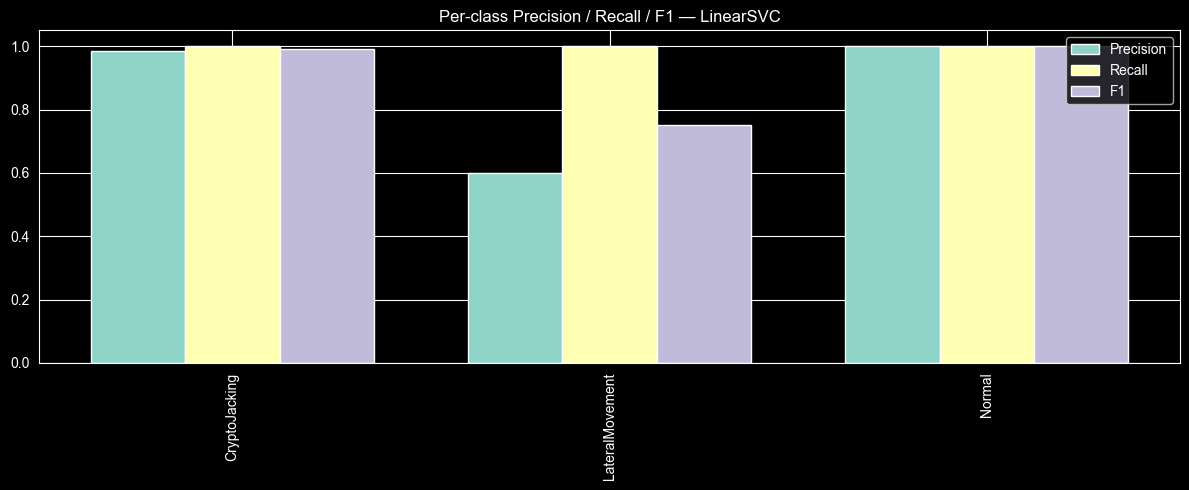

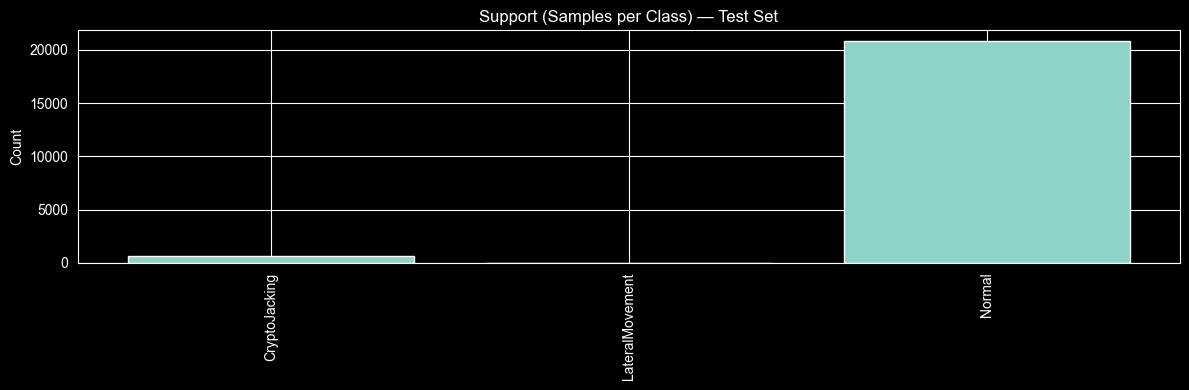

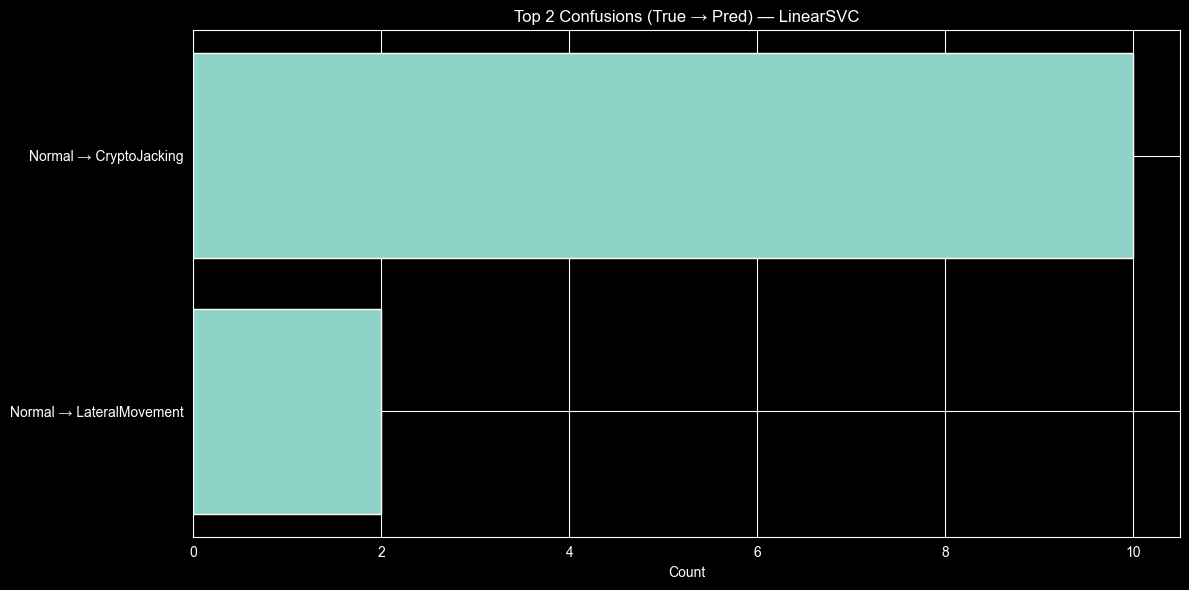

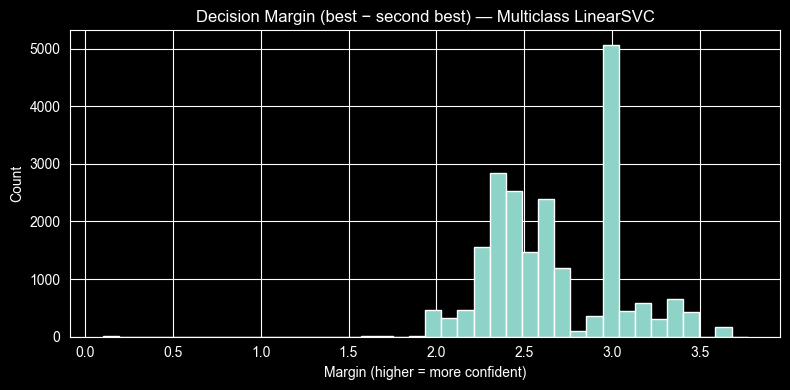


Hardest examples (lowest margins):
idx=17053  true=2  pred=2  margin=0.1005
idx= 7101  true=2  pred=2  margin=0.1005
idx=15520  true=2  pred=0  margin=0.1715
idx= 6942  true=2  pred=0  margin=0.1715
idx=14026  true=2  pred=0  margin=0.1715
idx= 4692  true=2  pred=0  margin=0.1715
idx= 3607  true=2  pred=0  margin=0.1715
idx=10175  true=2  pred=0  margin=0.1715
idx= 1411  true=2  pred=0  margin=0.1715
idx= 1688  true=2  pred=2  margin=0.5041

Overall:
Accuracy: 0.9994398805078417
Macro F1: 0.9140180374127453

Classification report:
                  precision    recall  f1-score   support

  CryptoJacking       0.98      1.00      0.99       648
LateralMovement       0.60      1.00      0.75         3
         Normal       1.00      1.00      1.00     20773

       accuracy                           1.00     21424
      macro avg       0.86      1.00      0.91     21424
   weighted avg       1.00      1.00      1.00     21424



In [11]:
# cell 10
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    precision_recall_fscore_support,
    accuracy_score,
    f1_score,
)


estimator = None

# Try common variable names first (edit these if you want)
for name in ["clf", "svc", "model", "classifier", "linsvc", "linear_svc"]:
    if name in globals():
        estimator = globals()[name]
        break

# If nothing found, try to auto-pick any object that looks like a trained sklearn estimator
if estimator is None:
    candidates = []
    for name, obj in list(globals().items()):
        if hasattr(obj, "predict") and hasattr(obj, "fit"):
            candidates.append((name, obj))
    # Prefer a LinearSVC if present
    for name, obj in candidates:
        if obj.__class__.__name__ == "LinearSVC":
            estimator = obj
            break


if estimator is None:

    estimator = LinearSVC()
    estimator.fit(X_train, y_train)


#Predict (if pred not already computed)

if "pred" not in globals():
    pred = estimator.predict(X_test)


# Labels
if "le" in globals() and hasattr(le, "classes_"):
    labels = le.classes_
else:

    labels = np.unique(np.concatenate([np.unique(y_test), np.unique(pred)])).astype(str)


# 3) Confusion Matrix (Counts)

cm = confusion_matrix(y_test, pred)

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(cm, display_labels=labels).plot(
    ax=ax, xticks_rotation=90, values_format="d"
)
ax.set_title("Confusion Matrix — LinearSVC (Counts)")
plt.tight_layout()
plt.show()


# Confusion Matrix (Normalized by True class = Recall)

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    pred,
    display_labels=labels,
    normalize="true",          # row-normalized
    ax=ax,
    xticks_rotation=90,
    values_format=".2f",
)
ax.set_title("Confusion Matrix — LinearSVC (Normalized by True Class / Recall)")
plt.tight_layout()
plt.show()



all_classes = np.unique(np.concatenate([np.unique(y_test), np.unique(pred)]))

prec, rec, f1c, sup = precision_recall_fscore_support(
    y_test, pred, labels=all_classes, zero_division=0
)

# Align label display length
disp_labels = labels
if len(disp_labels) != len(all_classes):
    disp_labels = all_classes.astype(str)

x = np.arange(len(all_classes))

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(x - 0.25, prec, width=0.25, label="Precision")
ax.bar(x,         rec,  width=0.25, label="Recall")
ax.bar(x + 0.25, f1c,   width=0.25, label="F1")
ax.set_xticks(x)
ax.set_xticklabels(disp_labels, rotation=90)
ax.set_ylim(0, 1.05)
ax.set_title("Per-class Precision / Recall / F1 — LinearSVC")
ax.legend()
plt.tight_layout()
plt.show()


#Support per class (bar chart)

fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(x, sup)
ax.set_xticks(x)
ax.set_xticklabels(disp_labels, rotation=90)
ax.set_ylabel("Count")
ax.set_title("Support (Samples per Class) — Test Set")
plt.tight_layout()
plt.show()


#Top confusions (largest off-diagonal errors)

cm_off = cm.copy()
np.fill_diagonal(cm_off, 0)

N = 15
pairs = np.dstack(np.unravel_index(np.argsort(cm_off.ravel())[::-1], cm_off.shape))[0]
pairs = [(i, j, cm_off[i, j]) for i, j in pairs if cm_off[i, j] > 0][:N]

if len(pairs) == 0:
    print("No off-diagonal confusions found.")
else:
    pair_labels = [f"{disp_labels[i]} → {disp_labels[j]}" for i, j, _ in pairs]
    pair_vals = [v for _, _, v in pairs]

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.barh(pair_labels[::-1], pair_vals[::-1])
    ax.set_title(f"Top {len(pairs)} Confusions (True → Pred) — LinearSVC")
    ax.set_xlabel("Count")
    plt.tight_layout()
    plt.show()


#Decision margin histogram (confidence proxy) + hardest examples

if hasattr(estimator, "decision_function"):
    scores = estimator.decision_function(X_test)

    if scores.ndim == 1:
        margins = np.abs(scores)
        title = "Decision Margin |distance| — Binary LinearSVC"
    else:
        sorted_scores = np.sort(scores, axis=1)
        margins = sorted_scores[:, -1] - sorted_scores[:, -2]
        title = "Decision Margin (best − second best) — Multiclass LinearSVC"

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist(margins, bins=40)
    ax.set_title(title)
    ax.set_xlabel("Margin (higher = more confident)")
    ax.set_ylabel("Count")
    plt.tight_layout()
    plt.show()

    k = 10
    hardest_idx = np.argsort(margins)[:k]
    print("\nHardest examples (lowest margins):")
    for idx in hardest_idx:
        # Works if y_test/pred are int-encoded; otherwise prints raw values
        print(f"idx={idx:5d}  true={y_test[idx]}  pred={pred[idx]}  margin={margins[idx]:.4f}")
else:
    print("Estimator has no decision_function; skipping margin plots.")


#Summary numbers + report

print("\nOverall:")
print("Accuracy:", accuracy_score(y_test, pred))
print("Macro F1:", f1_score(y_test, pred, average="macro"))

# classification_report needs target_names length to match labels present; safest is to omit target_names if mismatch
try:
    print("\nClassification report:\n", classification_report(y_test, pred, target_names=disp_labels, zero_division=0))
except Exception:
    print("\nClassification report:\n", classification_report(y_test, pred, zero_division=0))


In [ ]:
%%sql
